In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.morphology
import statistics as stat

In [2]:
def make_histogram_y(img):
    '''
    Organiza os dados da projeção horizontal na imagem
    
    Entrada:
    img -> Array da imagem
    
    Saída:
    hist -> Array com os valores do histograma de projeção horizontal
    '''

    height, width = img.shape

    hist = np.zeros(height)
    for x in range(height):
        for y in range(width):
            if (img[x][y] == 1):
                hist[x] += 1
    
    return hist

In [3]:
def make_histogram_x(img):
    '''
    Organiza os dados da projeção vertical na imagem, essa projeção só pode ser
    feita se a imagem de entrada possuir apenas uma única linha de caracteres
    braiile
    
    Entrada:
    img -> Array da imagem
    
    Saída:
    hist -> Array com os valores do histograma de projeção vertical
    '''

    height, width = img.shape

    hist = np.zeros(width)
    for x in range(height):
        for y in range(width):
            if (img[x][y] == 1):
                hist[y] += 1
    
    return hist

In [4]:
def get_delimiters(hist):
    '''
    Encontra os delimitadores verticais e horizontais da posição onde se
    encontram os pontos dos caracteres braille por meio do histograma

    Entrada:
    hist --> Array com os valores do histograma

    Saída:
    delimiters --> Array com os delimitadores de posição dos pontos

    '''
    delimiters = list()
    for i in range(1, len(hist)-1):
        if (hist[i] > 0) and (hist[i-1] == 0) and (hist[i+1] > 0):
            delimiters.append(i-1)
        if (hist[i] > 0) and (hist[i-1] > 0) and (hist[i+1] == 0):
            delimiters.append(i+1)

    return delimiters

In [5]:
def get_line_delimiters(delimiters):
    '''
    Encontra os delimitadores que determinam onde começam e onde terminam
    as linhas de texto braille da imagem

    Entrada:
    delimiters --> Array com os delimitadores de posição dos pontos

    Saída:
    line_delimiters --> Array com os delimitadores de linha
    '''

    distances = list()
    for i in range(len(delimiters)-1):
        distances.append(delimiters[i+1] - delimiters[i])
        # print(f"{delimiters[i+1]} - {delimiters[i]}", end='\n')
    distances = np.array(distances)
    # print(distances)

    min = distances.min() # Distância entre linhas de pontos de um mesmo caractere
    mode = stat.mode(distances) # Diâmetro dos pontos
    # print(mode)

    if (mode - min) > 2:
        limiar = min+2
    else:
        limiar = min+1

    line_delimiters = list()
    for i in range(1, len(delimiters)-2):

        if (distances[i] > mode and distances[i+1] > limiar and distances[i-1] > limiar):

            line_delimiters.append(delimiters[i])
            line_delimiters.append(delimiters[i+1])
        if i-1 == 0:
            line_delimiters.append(delimiters[i-1])
        if i+1 == len(delimiters)-2:
            line_delimiters.append(delimiters[i+2])

    return line_delimiters

In [6]:
def get_character_delimiters(delimiters):
    '''
    Utiliza os delimitadores de posição para determinar os delimitadores dos 
    caracteres braille por meio do cálculo de suas distâncias

    Entrada:
    delimiters --> Array com os delimitadores de posição dos pontos

    Saída:
    character_delimiters --> Array com os delimitadores dos caracteres
    '''

    distances = list()
    for i in range(len(delimiters)-1):
        distances.append(delimiters[i+1] - delimiters[i])
        # print(f"{delimiters[i+1]} - {delimiters[i]}", end='\n')
    distances = np.array(distances)
    min = distances.min()
    mode=stat.mode(distances)

    if (mode - min) > 2:
        limiar = min+2
    else:
        limiar = min+1
    # print(limiar)
    # print(distances)

    character_delimiters = list()
    for i in range(len(delimiters)-1):

        # Delimitando os caracters que possuem pontos nas duas colunas
        diameter = mode
        if (distances[i] <= limiar and distances[i] != mode-1 ):
            if i != 0:
                diameter = delimiters[i] - delimiters[i-1]
            character_delimiters.append(delimiters[i] - diameter)
            character_delimiters.append(delimiters[i+1] + diameter)

            
        #Delimitando os caracteres de início e final de linha
        elif i == 0 and distances[i+1] > limiar:
            # Caso em que o caractere possui pontos apenas na coluna da esquerda
            if (distances[i+1] > mode+limiar):
                character_delimiters.append(delimiters[i+1] + min + mode)
                character_delimiters.append(delimiters[i])
            # Caso em que o caractere possui pontos apenas na coluna da direita
            else:
                character_delimiters.append(delimiters[i] - min - mode)
                character_delimiters.append(delimiters[i+1])
    
        elif (i == len(distances)-1) and distances[i-1] > limiar:
            # Caso em que o caractere possui pontos apenas na coluna da direita
            if (distances[i-1] > mode+limiar and distances[i-3] > limiar):
                character_delimiters.append(delimiters[i-1] - min - mode)
                character_delimiters.append(delimiters[i])
            # Caso em que o caractere possui pontos apenas na coluna da esquerda
            else:
                character_delimiters.append(delimiters[i+1] + min + mode)
                character_delimiters.append(delimiters[i])

        # Delimitando os caracteres que possuem pontos apenas na coluna da esquerda
        if (distances[i] > 1.5*mode+min):
            if i > 1 and distances[i-2] > limiar:
                character_delimiters.append(delimiters[i] + min + mode)
                character_delimiters.append(delimiters[i-1])
        
        # Delimitando os caracteres que possuem pontos apenas na coluna da direita
        elif ((distances[i] > 1.5*mode+min) and (i < len(delimiters)-3) and
            (distances[i+2] > limiar)):
            # if (i < len(delimiters_x)-3) and distances[i+2] > min+1:
                character_delimiters.append(delimiters[i+2])
                character_delimiters.append(delimiters[i+1] - min - mode)
            # elif i == len(delimiters)-2:
            #     character_delimiters.append(delimiters[i+2])
            #     character_delimiters.append(delimiters[i+1] - min - mode)

        # Delimitando os caracteres de espaço em branco
        if (distances[i] >= 3*mode+min):
            character_delimiters.append(delimiters[i] + mode)
            character_delimiters.append(delimiters[i+1] - mode)

    return character_delimiters

In [7]:
def get_line_subimages(img, line_delimiters):
    '''
    Utiliza os delimitadores de linha para recortar a imagem em subimagens, cada
    uma com uma linha de carateres braille
    
    Entrada:
    img -> Array da imagem que será recortada
    line_delimiters --> Array com os delimitadores de linha
    
    Saída:
    line_subimages --> Array com subimagens das linhas recortadas
    '''
    line_delimiters = sorted(line_delimiters)
    line_subimages = list()
    for i in range(len(line_delimiters)//2):
        line_subimages.append(img[line_delimiters[2*i]:line_delimiters[2*i+1],:])
    return line_subimages

In [8]:
def get_character_subimages(img, char_delimiters):
    '''
    Recorta a imagem que contém uma linha de caracteres braille em subimagens 
    contendo os caracteres, que por sua vez são armazenadas em um array na ordem
    de leitura

    Entrada:
    img --> Array da imagem contendo um linha de caracteres
    char_delimiters --> Array com os delimitadores dos caracteres

    Saída:
    subimages --> Array com as subimagens dos caracteres
    '''

    char_delimiters = sorted(char_delimiters)
    for i in range(len(char_delimiters)):
        if char_delimiters[i] < 0:
            char_delimiters[i] = 0

    char_subimages = list()
    for i in range(len(char_delimiters)//2):
        char_subimages.append(img[:,char_delimiters[2*i]:char_delimiters[2*i+1]])
    return char_subimages

In [9]:
def optical_braille_recognition(img):
    '''
    Recebe uma imagem pré-processada contendo um texto em braille, detecta a
    posição desses caracters na imagem e apartir disso obtem uma matriz de
    subimagens contendo os caracteres braille

    Entrada:
    img --> Array da imagem pré-processada

    Saída:
    subimages --> matriz de subimagens contendo os caracteres braille
    '''

    hist_y = make_histogram_y(img)
    delimiters_y = get_delimiters(hist_y)
    line_delimiters = get_line_delimiters(delimiters_y)
    line_subimages = get_line_subimages(img, line_delimiters)

    subimages = list()
    for i in range(len(line_subimages)):
        hist_x = make_histogram_x(line_subimages[i])
        delimiters_x = get_delimiters(hist_x)
        char_delimiters = get_character_delimiters(delimiters_x)
        char_subimages = get_character_subimages(line_subimages[i], char_delimiters)
        subimages.append(char_subimages)

    return subimages


Verificando o histograma de uma imagem com o texto braille inclinado

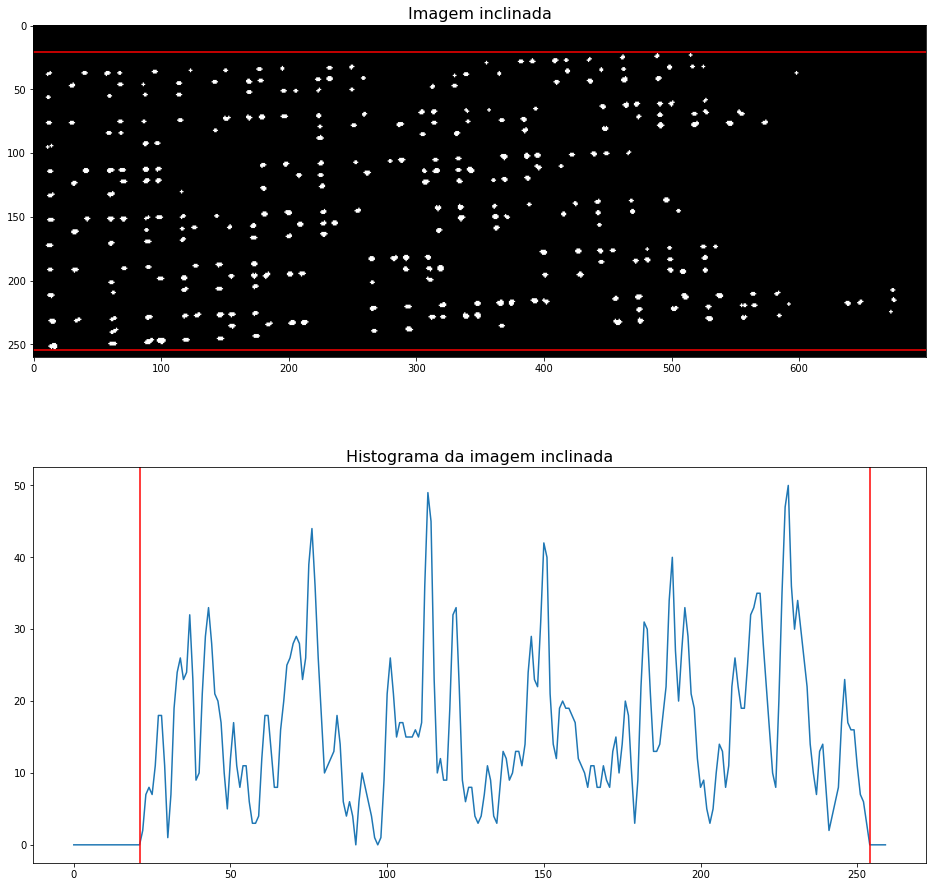

In [10]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/imagens/braille_inclinado.png", 0)
_ , img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
img_bin = (~img_bin)/255

# Realizando erosão seguida de dilatação para separar pontos conectados
kernel = skimage.morphology.disk(1)
dst_img = cv2.erode( img_bin, kernel, iterations = 1 )
img_bin = cv2.dilate( dst_img, kernel, iterations = 1 )

hist_y = make_histogram_y(img_bin)
delimiters_y = get_delimiters(hist_y)
line_delimiters = get_line_delimiters(delimiters_y)

x = np.arange(len(hist_y))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,16))
axs[0].imshow(img_bin, cmap='gray')
axs[0].set_title("Imagem inclinada", fontsize=16)
axs[1].plot(x, hist_y)
axs[1].set_title("Histograma da imagem inclinada", fontsize=16)

for lx in line_delimiters:
    axs[1].axvline(lx, color='red')

for ly in line_delimiters:
    axs[0].axhline(ly, color='red')

Histograma da mesma imagem só que agora com uma correção de inclinação


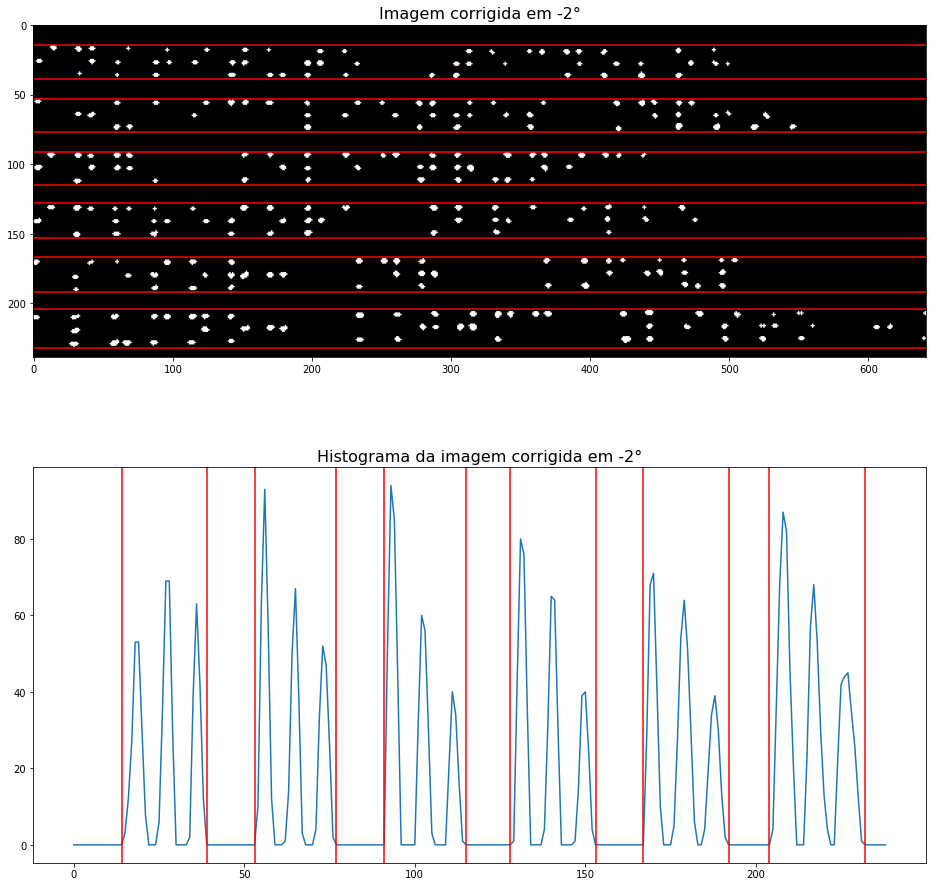

In [11]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/imagens/braille_corrigido.png", 0)
# img_blur = cv2.GaussianBlur(img, (7,7), 0.5)
_ , img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
# img_bin = preprocessing_canny(img)
# img_bin = preprocessing_sobel(img)
# img_blur = cv2.GaussianBlur(img, (7,7), 0.5)
# limiar, img_bin = cv2.threshold( img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
# img_bin = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
img_bin = (~img_bin)/255

# Realizando erosão seguida de dilatação para separar pontos conectados
kernel = skimage.morphology.disk(1)
dst_img = cv2.erode( img_bin, kernel, iterations = 1 )
img_bin = cv2.dilate( dst_img, kernel, iterations = 1 )

hist_y = make_histogram_y(img_bin)
delimiters_y = get_delimiters(hist_y)
line_delimiters = get_line_delimiters(delimiters_y)

x = np.arange(len(hist_y))
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,16))
axs[0].imshow(img_bin, cmap='gray')
axs[0].set_title("Imagem corrigida em -2°", fontsize=16)
axs[1].plot(x, hist_y)
axs[1].set_title("Histograma da imagem corrigida em -2°", fontsize=16)

for lx in line_delimiters:
    axs[1].axvline(lx, color='red')

for ly in line_delimiters:
    axs[0].axhline(ly, color='red')

In [12]:
subimages1 = optical_braille_recognition(img_bin)

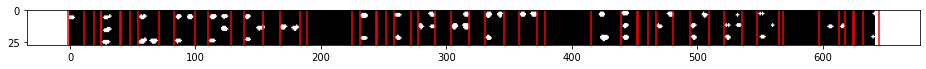

In [13]:
line_subimg = get_line_subimages(img_bin, line_delimiters)

i = 5
hist_x = make_histogram_x(line_subimg[i])
delimiters_x = get_delimiters(hist_x)
char_delimiters = get_character_delimiters(delimiters_x)
char_subimages = get_character_subimages(line_subimg[i], char_delimiters)

plt.figure(figsize=(16,12))
plt.imshow(line_subimg[i], cmap="gray")
for lx in char_delimiters:
    plt.axvline(lx, color='red')

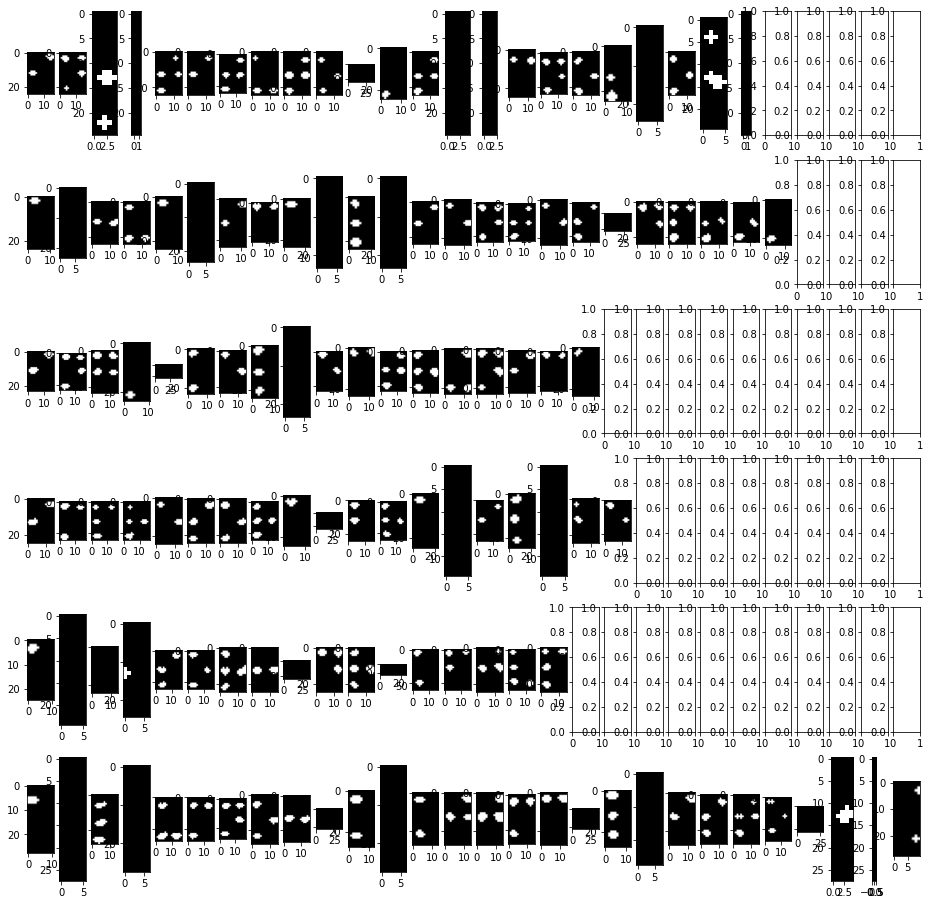

In [14]:
aux = list()
for i in range(len(subimages1)):
    aux.append(len(subimages1[i]))
max = np.max(aux)

fig, axs = plt.subplots(nrows=len(subimages1), ncols=max, figsize=(16,16))

for i in range(len(subimages1)):
    for j in range(len(subimages1[i])):
      axs[i][j].imshow(subimages1[i][j], cmap='gray')

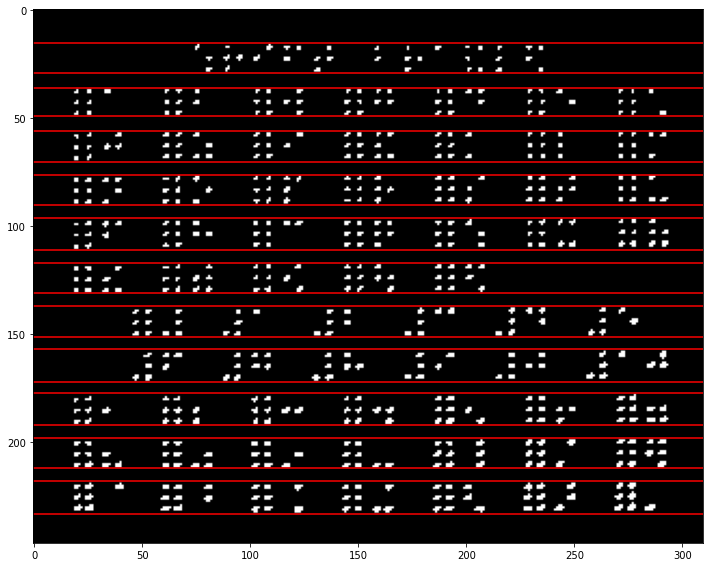

In [15]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/imagens/br2.jpg", 0)
_ , img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
img_bin = (~img_bin)/255

kernel = skimage.morphology.disk(1)

img_bin = cv2.dilate( img_bin, kernel, iterations = 1 )
img_bin = cv2.erode( img_bin, kernel, iterations = 1 )

plt.figure(figsize=(12,12))
plt.imshow(img_bin, cmap='gray')

hist_y = make_histogram_y(img_bin)
delimiters_y = get_delimiters(hist_y)
line_delimiters = get_line_delimiters(delimiters_y)

# x = np.arange(len(hist_y))
# plt.figure(figsize=(12,6))
# plt.plot(x, hist_y)

for ly in line_delimiters:
    plt.axhline(ly, color='red')

# for lx in line_delimiters:
#     plt.axvline(lx, color='red')

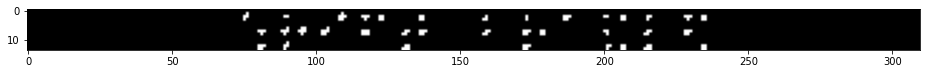

In [16]:
line_subimg = get_line_subimages(img_bin, line_delimiters)
plt.figure(figsize=(16,12))
plt.imshow(line_subimg[0], cmap='gray')

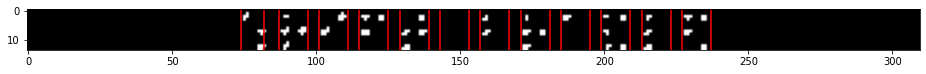

In [17]:
i = 0
hist_x = make_histogram_x(line_subimg[i])
delimiters_x = get_delimiters(hist_x)
char_delimiters = get_character_delimiters(delimiters_x)
char_subimages = get_character_subimages(line_subimg[i], char_delimiters)

plt.figure(figsize=(16,12))
plt.imshow(line_subimg[i], cmap="gray")
for lx in char_delimiters:
    plt.axvline(lx, color='red')

In [18]:
subimages2 = optical_braille_recognition(img_bin)

19


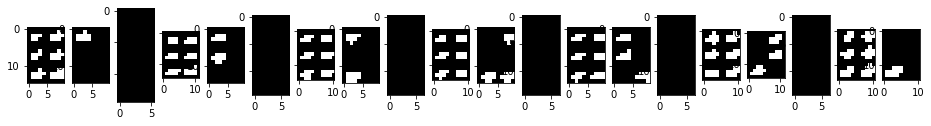

In [19]:
n = 10
fig, axs = plt.subplots(nrows=1, ncols=len(subimages2[n]), figsize=(16,14))
for i in range(len(subimages2[n])):
    axs[i].imshow(subimages2[n][i], cmap='gray')
print(i)

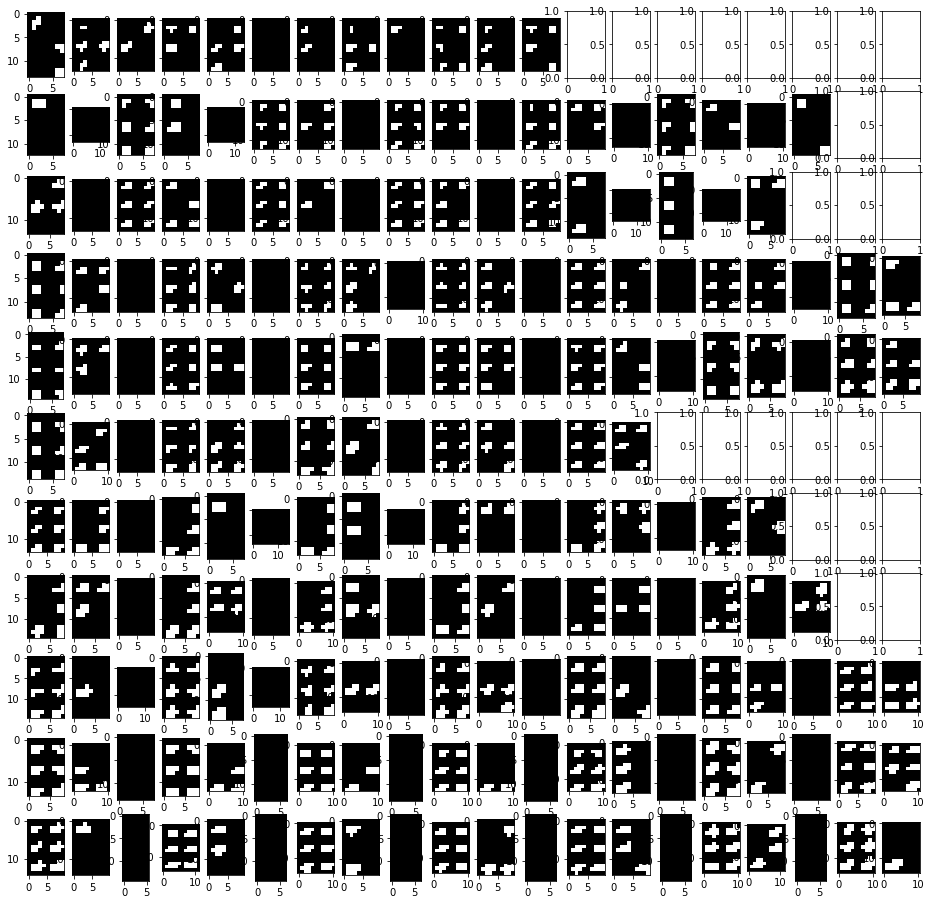

In [20]:
aux = list()
for i in range(len(subimages2)):
    aux.append(len(subimages2[i]))
max = np.max(aux)

fig, axs = plt.subplots(nrows=len(subimages2), ncols=max, figsize=(16,16))

for i in range(len(subimages2)):
    for j in range(len(subimages2[i])):
      axs[i][j].imshow(subimages2[i][j], cmap='gray')